Can run all cells at startup; there is a flag for recalculating things that take a long time (otherwise loads in these things from previous calculations). 
- some cells hidden by default

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cPickle as pkl
import pandas as pd
import os,sys,glob, h5py

from braintv_ephys_dev.workstation.danield import generalephys as ephys
from braintv_ephys_dev.workstation.danield.generalephys import placeAxesOnGrid, cleanAxes
from braintv_ephys_dev.workstation.danield import utils
from braintv_ephys_dev.workstation.danield import rf_analysis
from braintv_ephys_dev.workstation.danield import psth_and_raster as psth
from braintv_ephys_dev.workstation.danield import reliability_and_precision as rp


#import from xiaoxuan's workstation
# sys.path.append('/Users/administrator/anaconda/lib/python2.7/site-packages/braintv_ephys_dev/workstation/jiaxx')
# from sparseness_life import sparseness

#import allensdk for corona plots
#sys.path.append('/Users/administrator/anaconda/lib/python2.7/site-packages/allensdk/allensdk')
#import allensdk.brain_observatory.circle_plots as cp

import seaborn as sns
sns.set_style('white')
%matplotlib inline
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')

In [2]:
folder = '/Volumes/DATA2/temporal/nwbs' 
#paths = glob.glob(folder+'/*.nwb')
v1_paths = [os.path.join(folder,'M276039_insertion2_V1_angled_sort2_2.nwb'),
        os.path.join(folder,'M310008_07-27-13_v1_angled_d.nwb'),
        os.path.join(folder,'M310008_07-35-06_v1_angled_d.nwb'),
        os.path.join(folder,'M310008_08-23-22_v1_angled1_d2.nwb'),
         os.path.join(folder,'M310008_08-52-48_v1_angled3_d2.nwb'),
        os.path.join(folder,'M310008_08-52-48_v1_angled3_d2.nwb'),
            os.path.join(folder,'M310017_09-23-41_v1_angled1.nwb'),
            os.path.join(folder,'M227382_insertion1_withDepths11.nwb'),
           os.path.join(folder,'M227398_insertion1_withEyetracking.nwb'),
            #os.path.join(folder,'M230381_insertion2_V1.nwb'),
            os.path.join(folder,'M260686_insertion1_V1_withEyetracking3.nwb'),
            os.path.join(folder,'M270512_insertion2_V1_angled3_6.nwb'),
            os.path.join(folder,'M276038_insertion3_V1_angled_7.nwb'),
           ]
lgn_paths = [#os.path.join(folder,'M227382_insertion2_LGN.nwb'),
            os.path.join(folder,'M260866_insertion2_withEyetracking1.nwb'),
            os.path.join(folder,'M270511_insertion5.nwb')]
dual_paths = glob.glob(os.path.join(folder,'M31989*.nwb'))
eye_paths = glob.glob(os.path.join(folder,'withEyetracking','*.nwb'))
figure_folder = '/Volumes/DATA2/temporal/figures'

In [3]:
dfs = [utils.df_from_nwb(path) for path in eye_paths]
df = pd.concat(dfs,ignore_index=True)

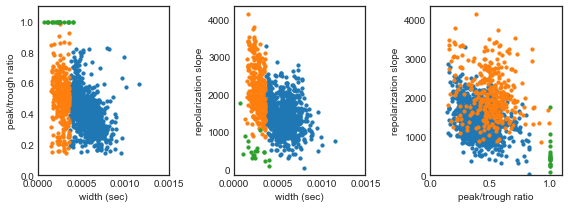

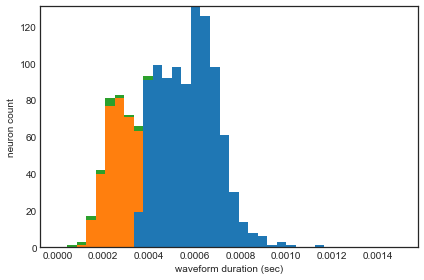

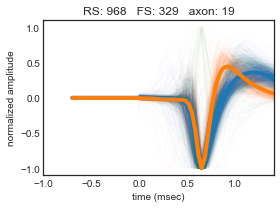

In [4]:
df = utils.classify_waveform_shape(df,plots=True,basepath='/Users/administrator/Dropbox/allenTransfer/temporal_figs')

In [5]:
structure = []
for index in df.index:
    if df.probe[index] == 'V1' or df.probe[index] == 'LGN':
        structure.extend([df.probe[index]])
    else:
        if df.depth[index] < 1000.:
            structure.extend(['V1'])
        else:
            if df.depth[index] > 1900.:
                structure.extend(['LGN'])
            else:
                structure.extend(['other'])
df['structure']=structure
df_lgn = df[df.structure=='LGN']
df_v1 = df[df.structure=='V1']

In [6]:
dfv = pd.concat([df_v1,df_lgn])

In [7]:
nwbs={}
for nwb_path in dfv.nwb_id.unique():
    try:
        nwbs[nwb_path]=h5py.File(nwb_path)
    except:
        print nwb_path

#### some example CCGs

In [32]:
nwb_path = '/Volumes/DATA2/temporal/nwbs/withEyetracking/M319892_dual_24082017_withEyetracking.nwb'
dft=dfv[dfv.nwb_id==nwb_path]
nwb_data = nwbs[nwb_path]
index1 = dft.index[7]
index2 = dft.index[3]
image_times = np.array(nwb_data['stimulus']['presentation']['natural_scenes']['timestamps'][::118])

In [33]:
noise_times = np.array(nwb_data['stimulus']['presentation']['binary']['timestamps'])

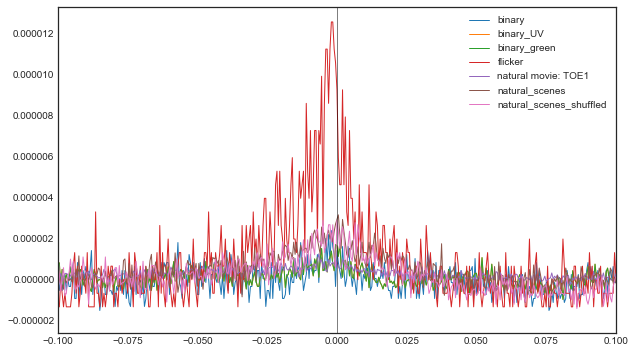

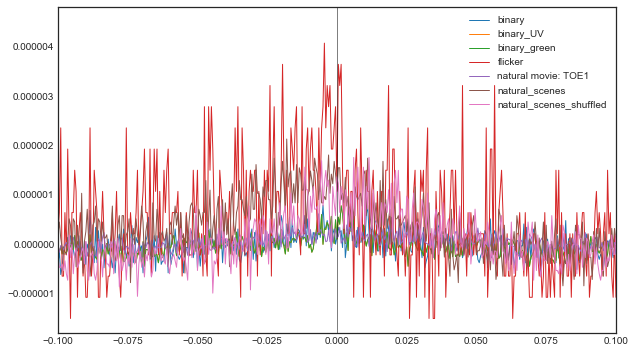

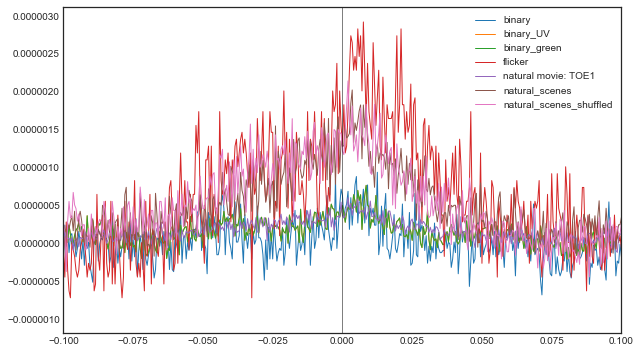

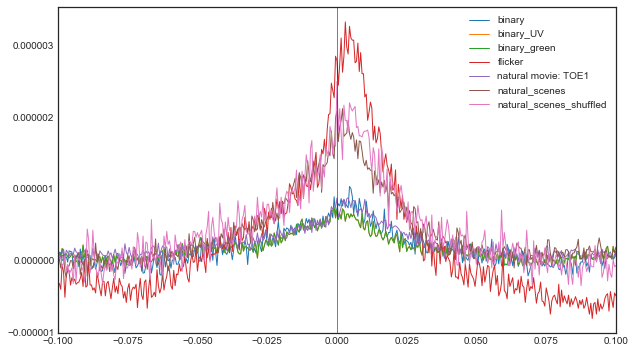

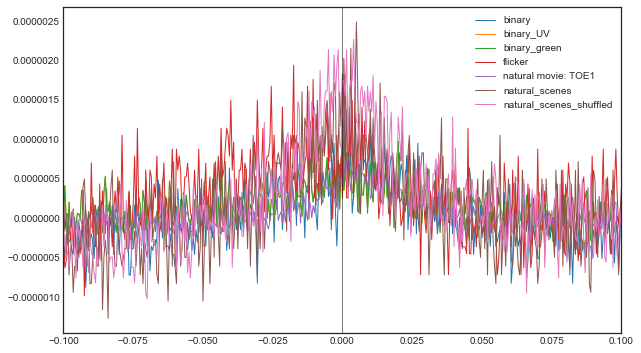

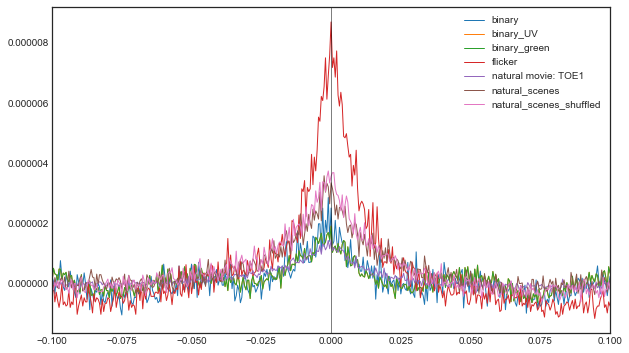

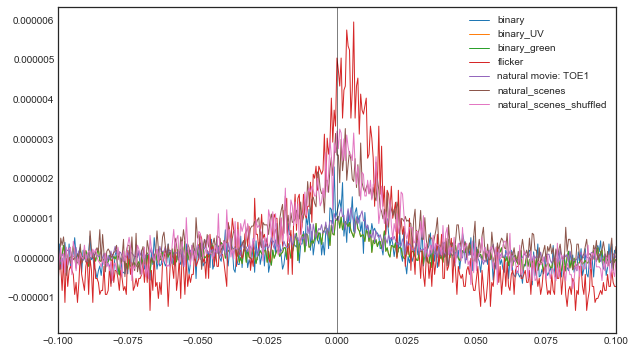

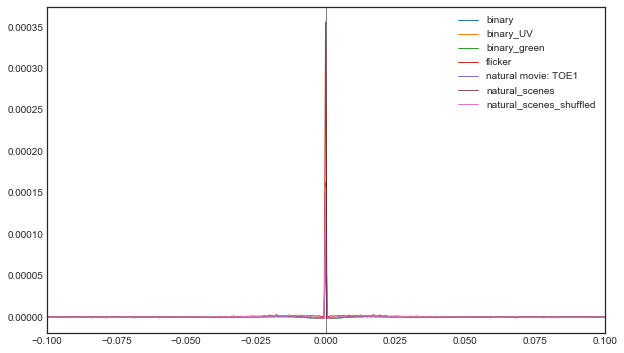

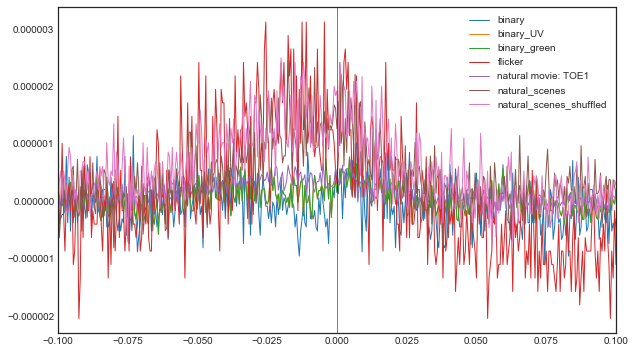

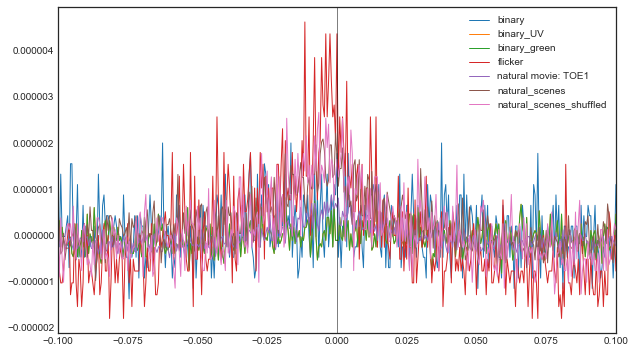

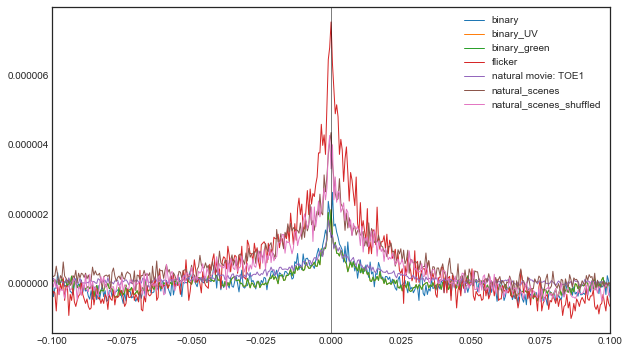

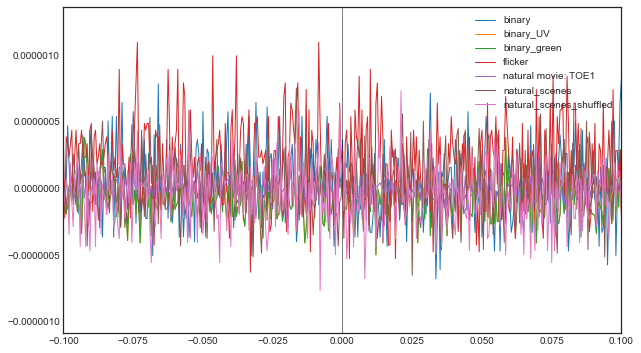

In [34]:
for cell in range(12):
    plt.figure(figsize=(10,6))
    train1 = dft.times[dft.index[cell]]
    train2 = dft.times[dft.index[7]]
    for stim in nwb_data['stimulus']['presentation'].keys()[:-1]:
        if stim != 'full field flashes':
            stimulus_times = np.array(nwb_data['stimulus']['presentation'][stim]['timestamps'])
            a = ephys.ccg(train1,train2,(-1,1),0.0005,spikerange=(stimulus_times[0],stimulus_times[-1]))
            plt.plot(a[1][:-1],a[0]-np.mean(a[0][:10]),label=stim,lw=1)
    plt.gca().axvline(0,color='k',lw=0.5)
    plt.xlim(-.10,.10)
    plt.gca().legend()

input spiketrains not long enough


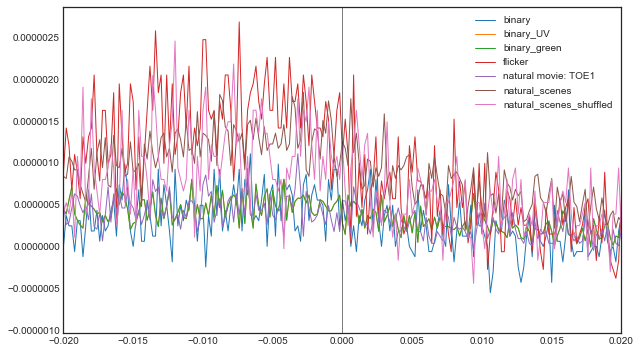

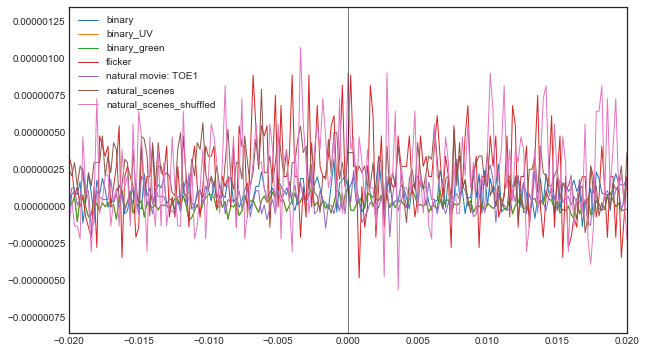

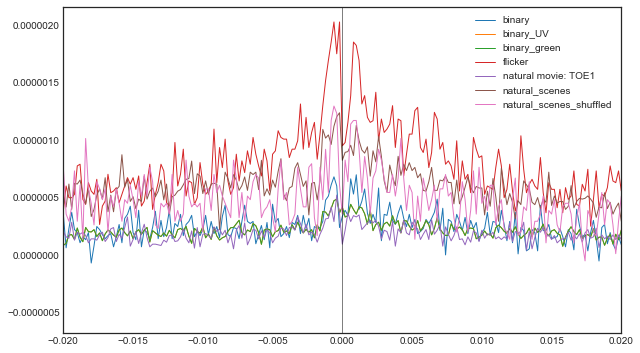

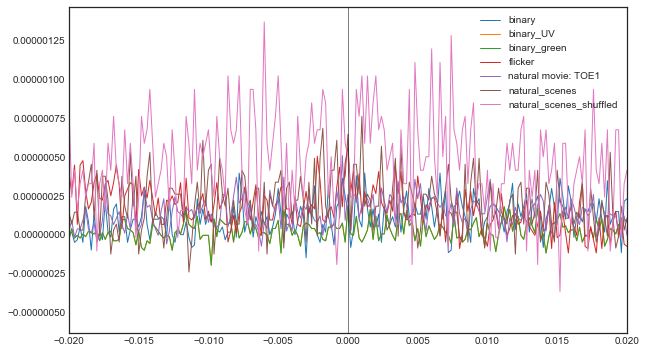

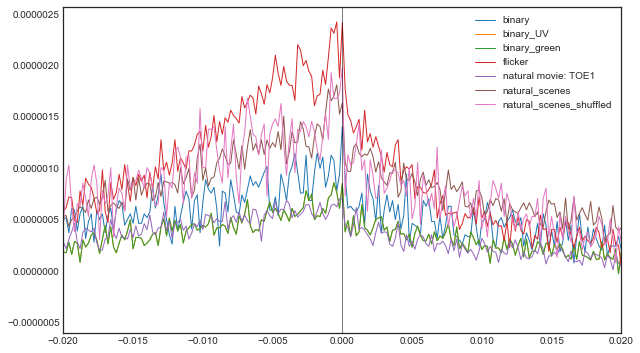

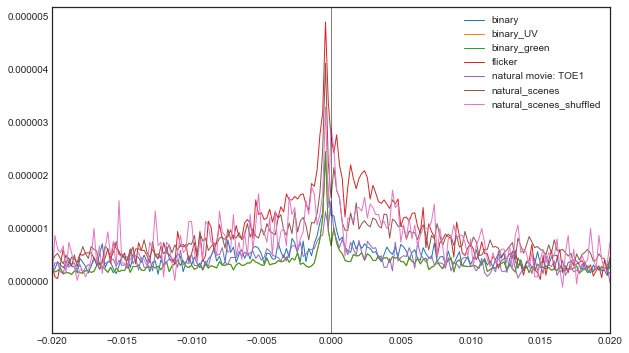

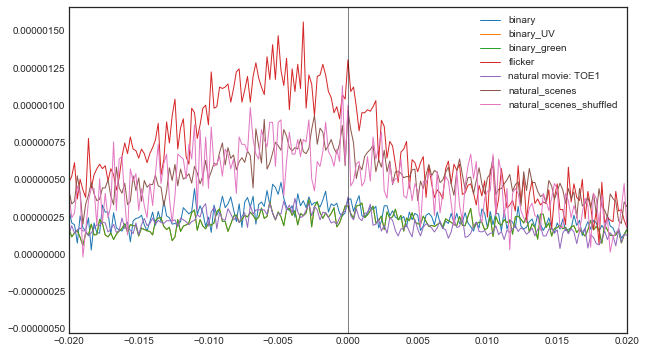

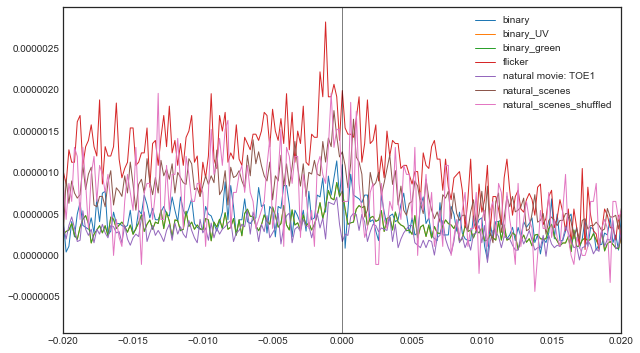

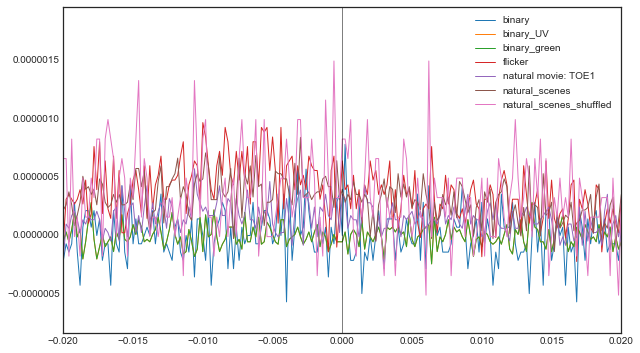

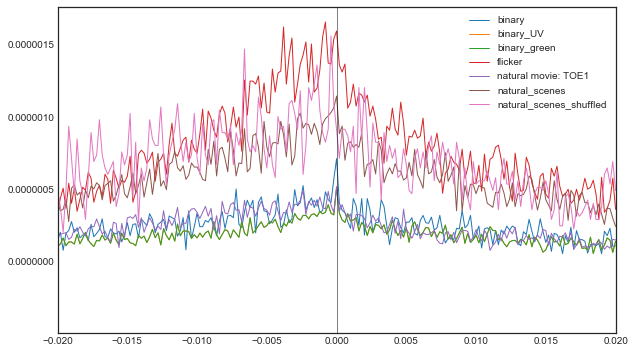

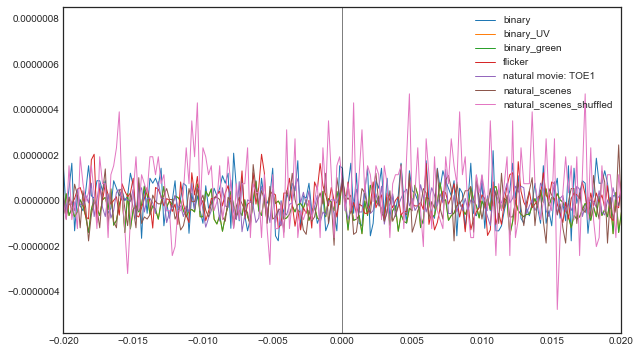

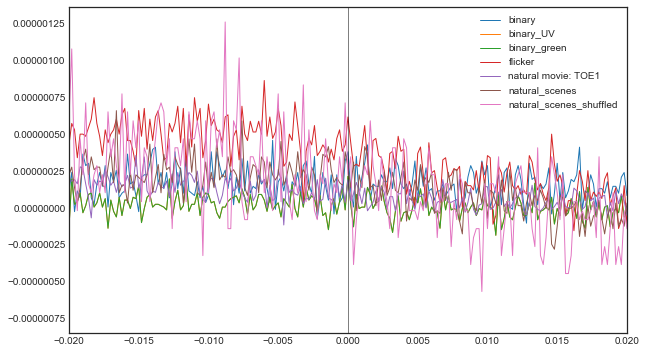

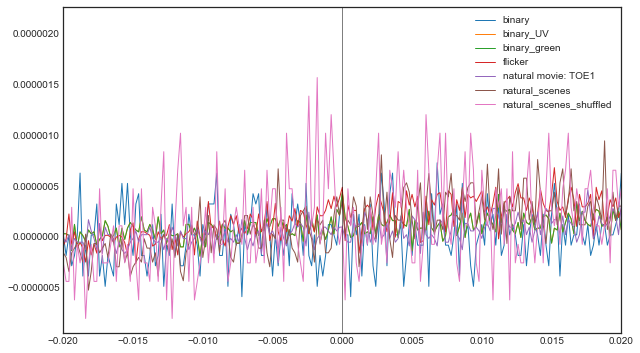

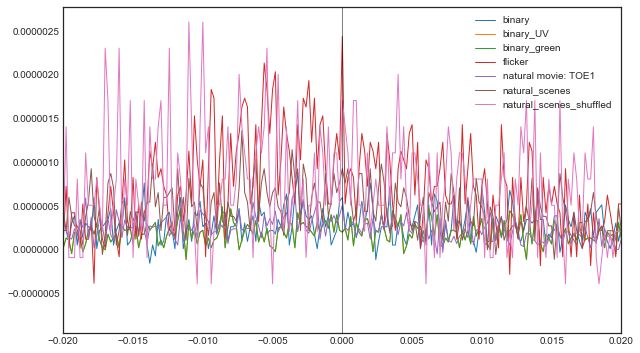

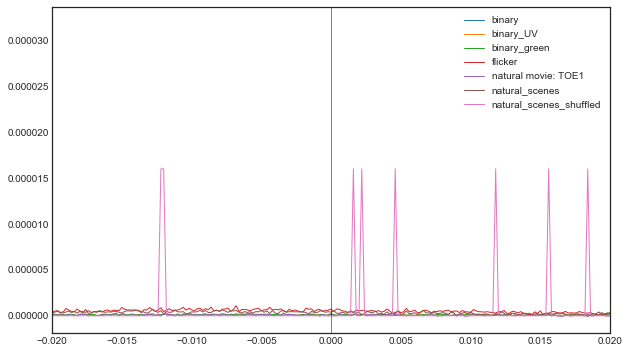

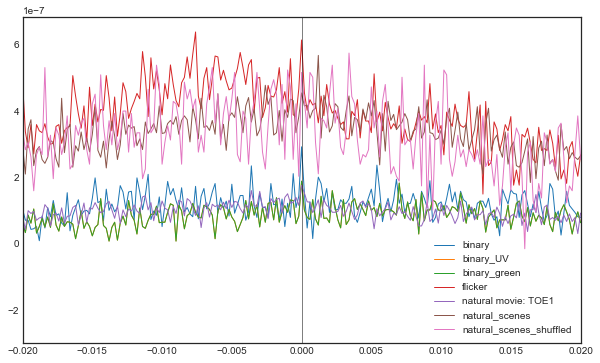

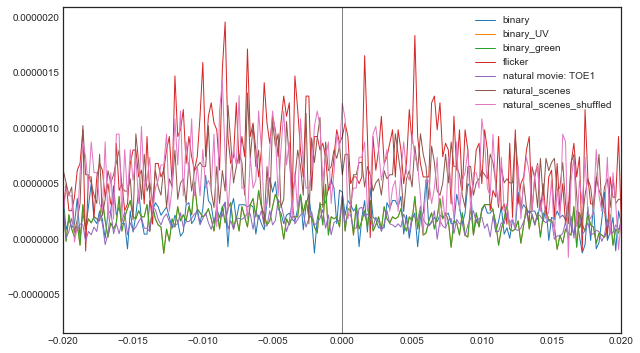

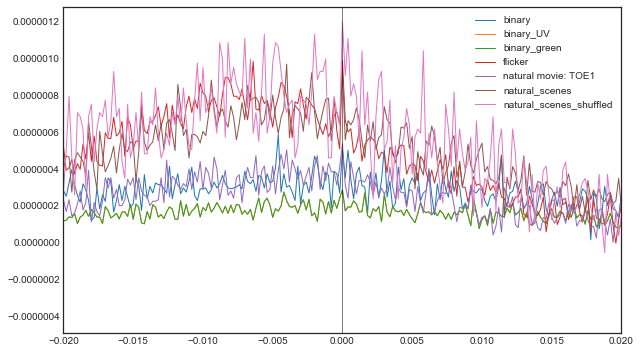

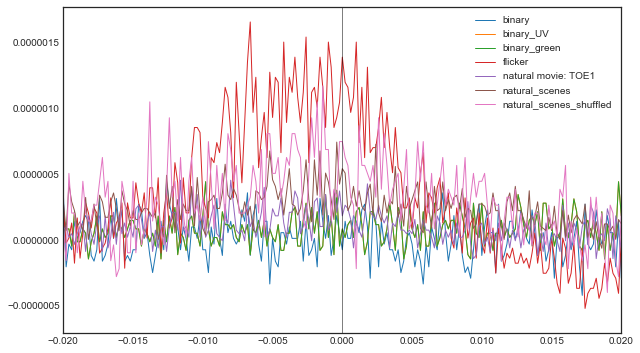

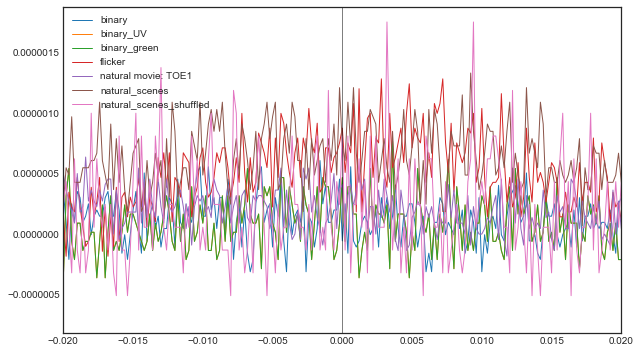

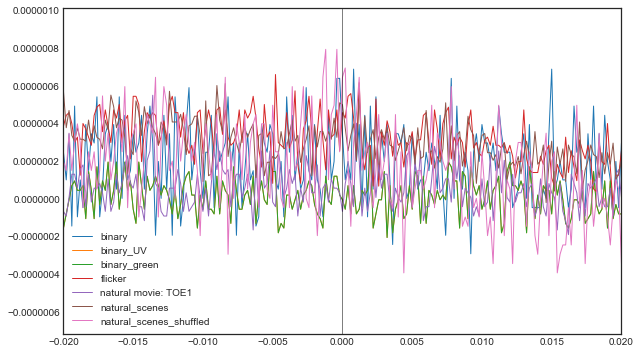

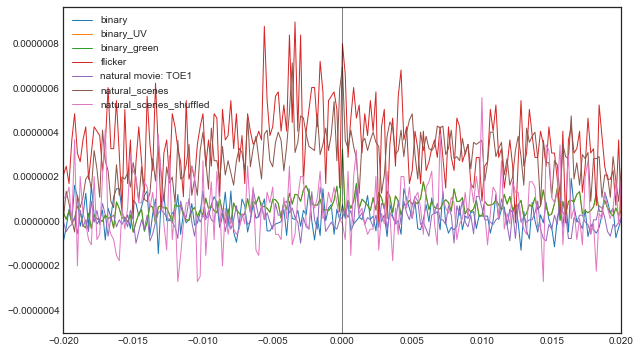

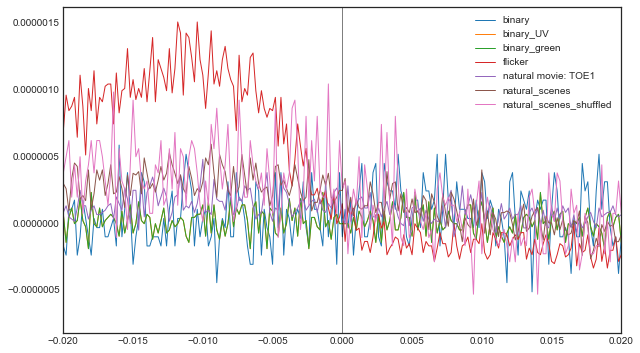

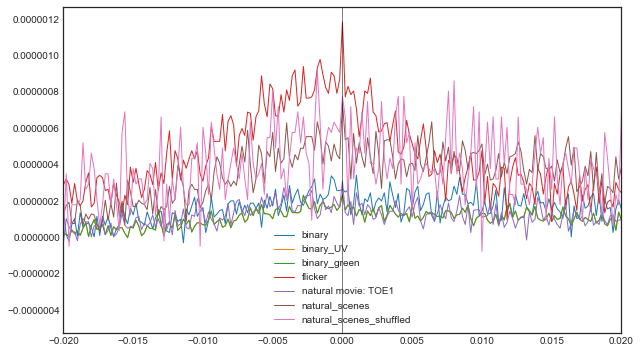

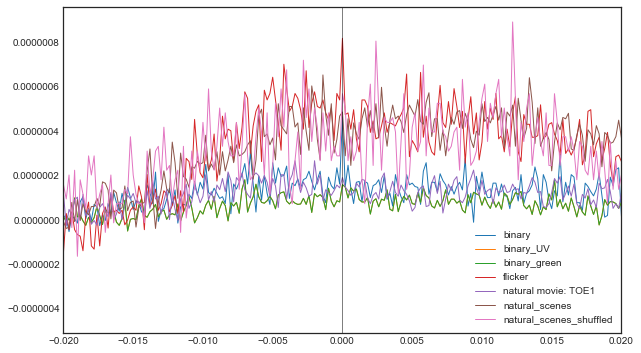

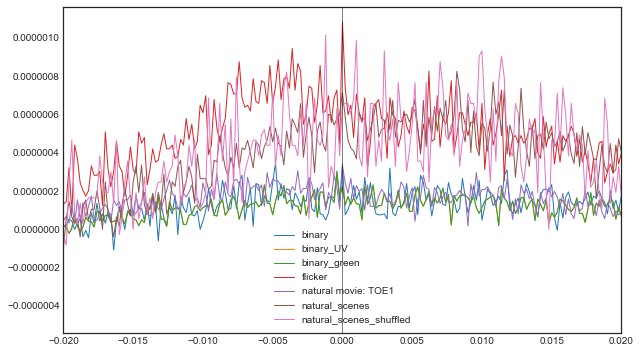

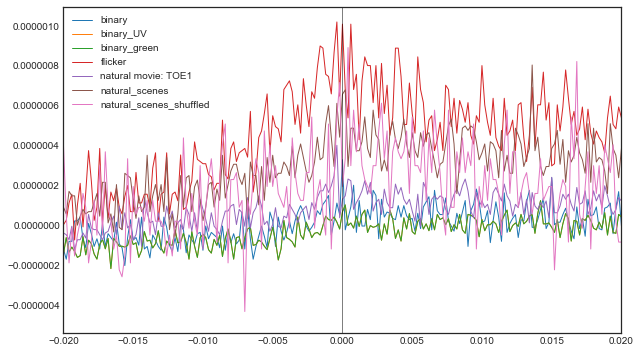

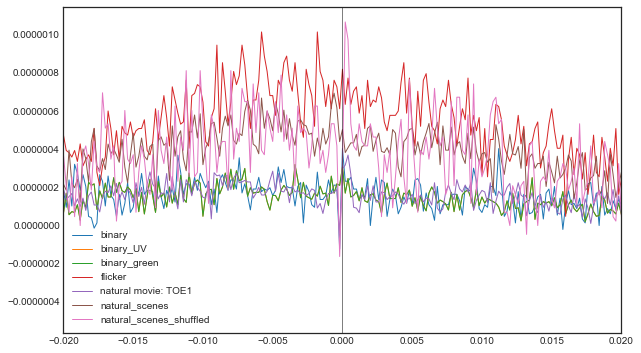

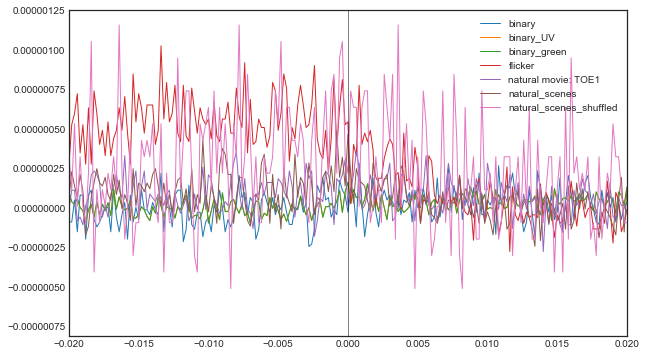

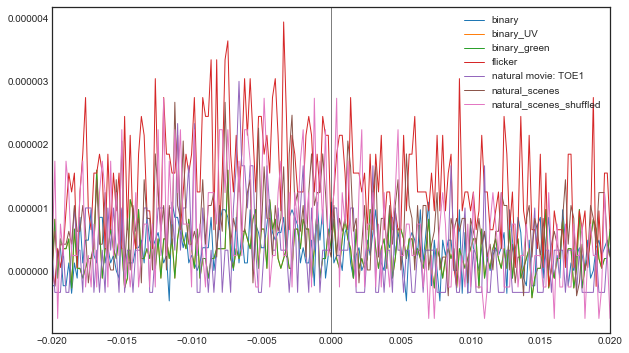

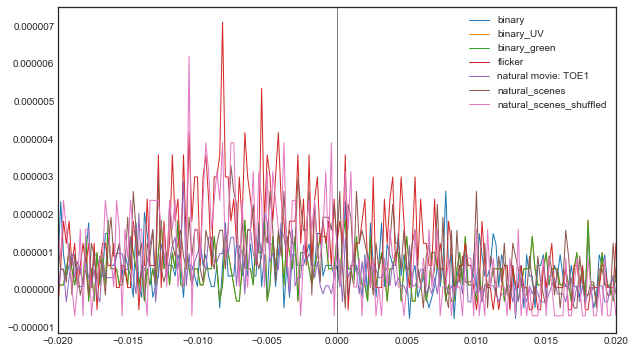

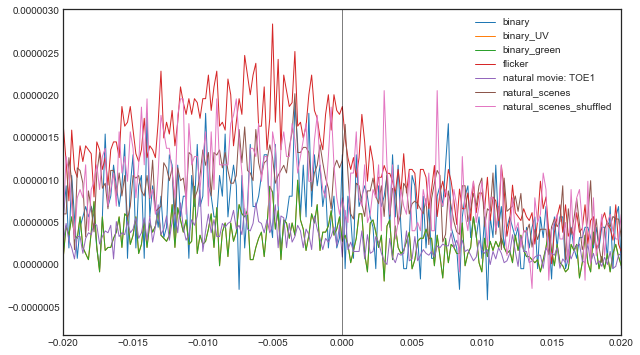

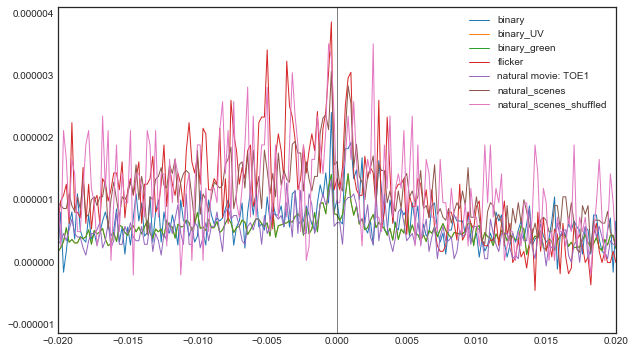

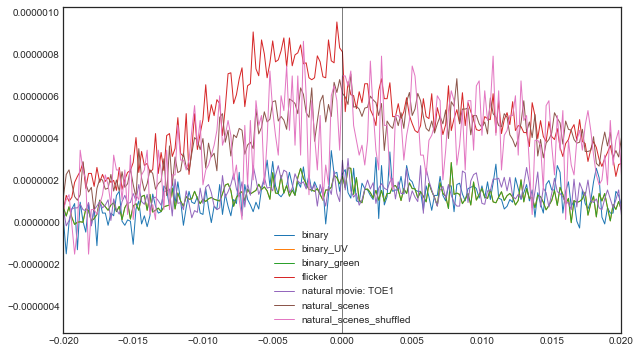

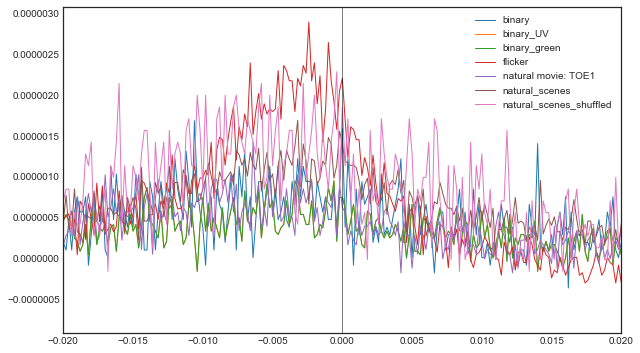

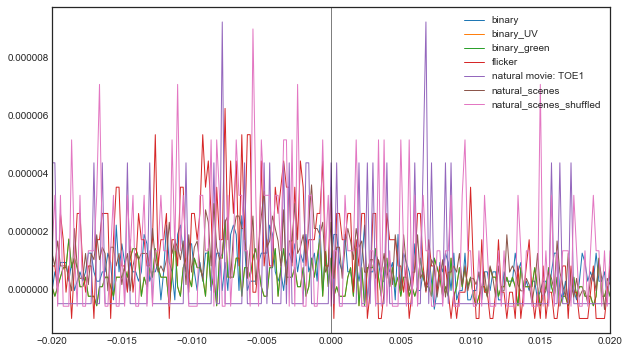

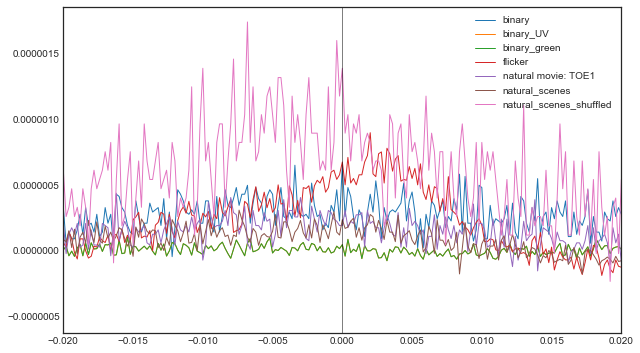

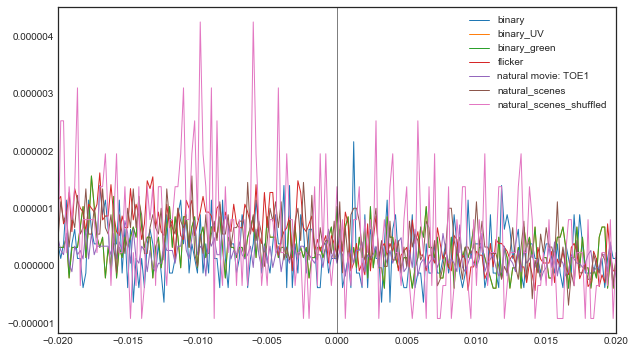

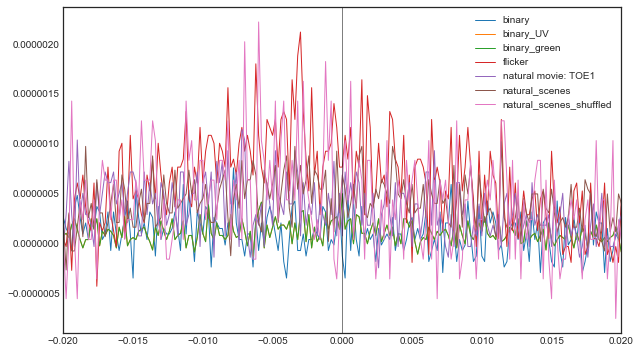

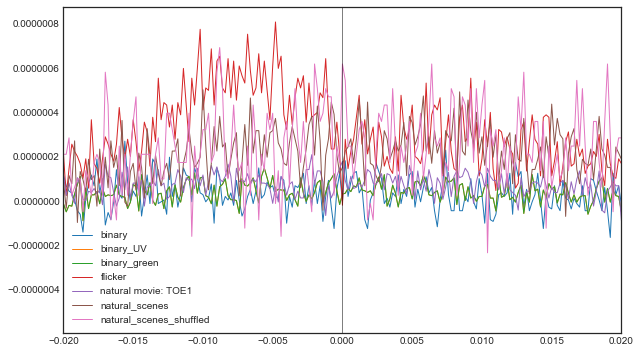

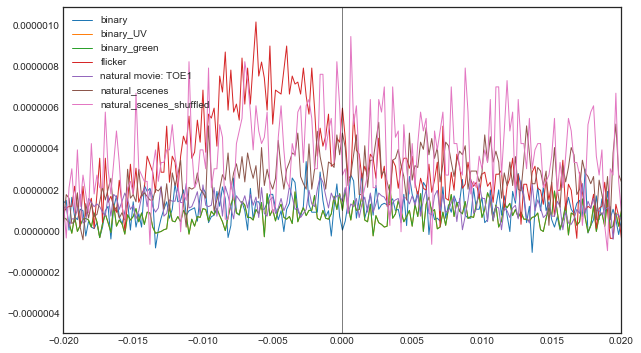

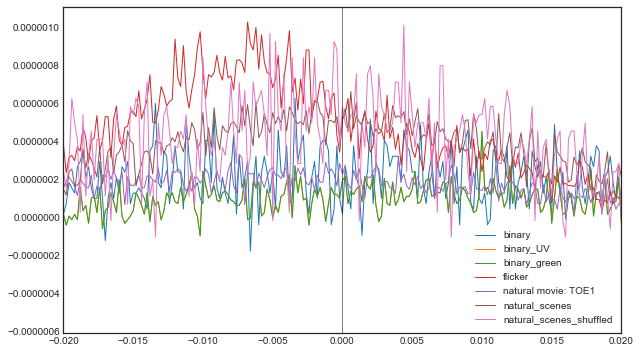

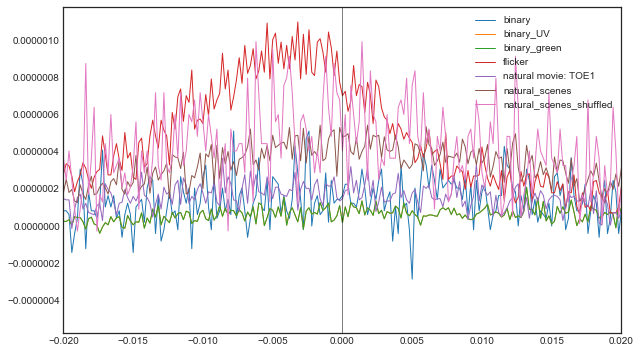

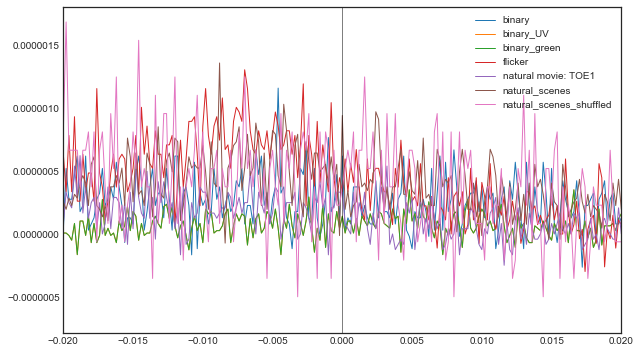

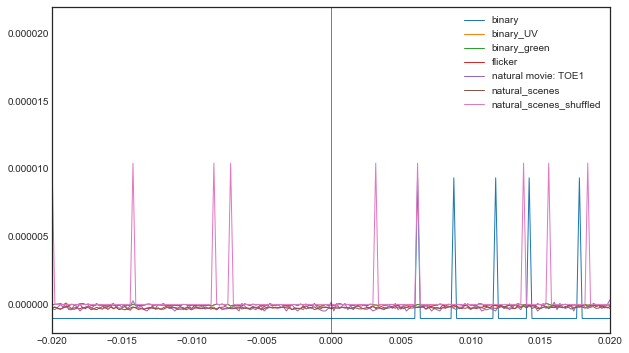

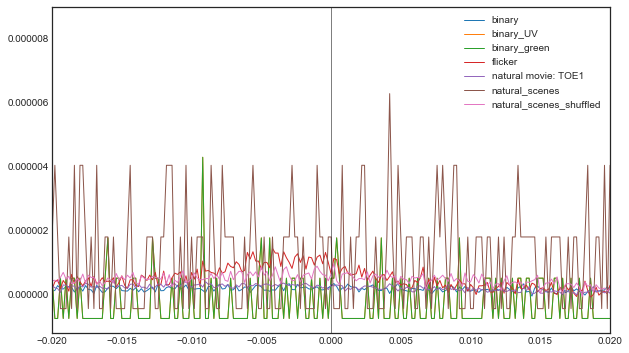

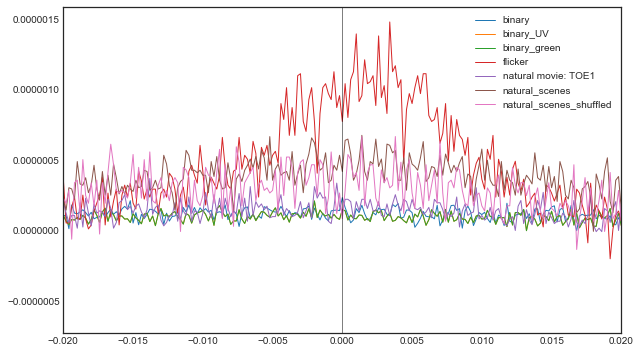

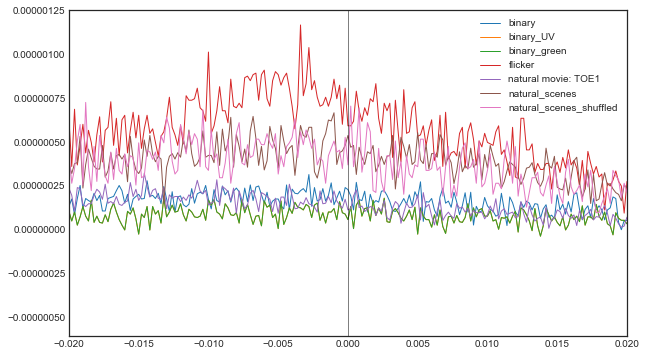

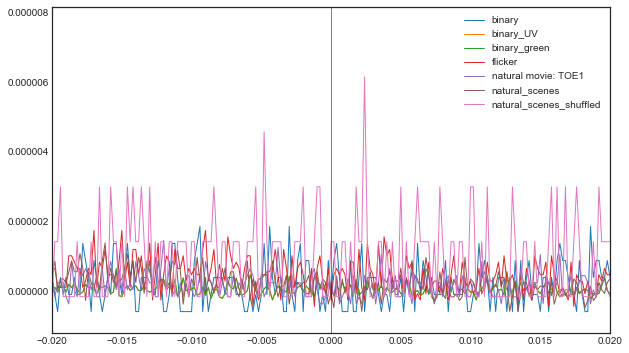

In [126]:
for cell in range(50):
    plt.figure(figsize=(10,6))
    train1 = dft.times[dft.index[cell]]
    train2 = dft.times[dft.index[3]]
    if cell != 3:
        for stim in nwb_data['stimulus']['presentation'].keys()[:-1]:
            if stim != 'full field flashes':
                stimulus_times = np.array(nwb_data['stimulus']['presentation'][stim]['timestamps'])
                a = ephys.ccg(train1,train2,(-1,1),0.0002,spikerange=(stimulus_times[0],stimulus_times[-1]))
                plt.plot(a[1][:-1],a[0]-np.mean(a[0][:10]),label=stim,lw=1)
        plt.gca().axvline(0,color='k',lw=0.5)
        plt.xlim(-.02,.02)
        plt.gca().legend()

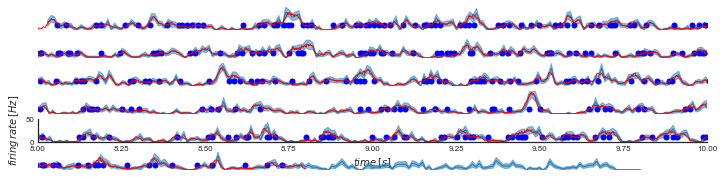

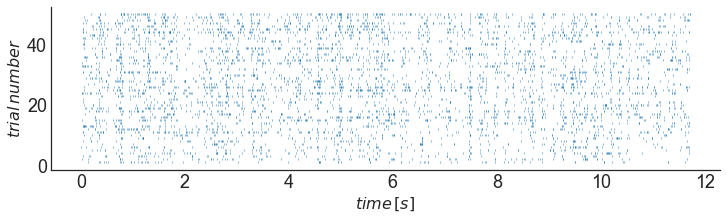

In [118]:
post=10.8

spike_times = dft.times[dft.index[6]]
stimulus_times =  np.array(nwb_data['stimulus']['presentation']['natural_scenes']['timestamps'][::118])
smoothed,minima,minima2 = rp.get_events(spike_times,stimulus_times,post=post,threshold=0.2,boxcar_size=10.,binsize=.002)

f,axes = plt.subplots(6,1,figsize=(12,3))
#ax.plot(ev,np.ones(len(ev))*10.,'bo')
for i,ax in enumerate(axes):
    if i !=4:
        psth.psth_line(spike_times,stimulus_times,pre=0.,post=post,binsize=0.01,output='fig',timeDomain=True,axes=ax,ymax=50,labels=False,error='shaded',color=sns.color_palette()[0])
        ephys.cleanAxes(ax,total=True)
    else:
        psth.psth_line(spike_times,stimulus_times,pre=0.,post=post,binsize=0.01,output='fig',timeDomain=True,axes=ax,ymax=50,labelsize=8,axis_labelsize=10,error='shaded',color=sns.color_palette()[0])
    #ax.plot(minima,np.ones(len(minima))*18.,'ro')
    ax.plot(minima2,np.ones(len(minima2))*post,'bo',ms=5)
    ax.plot(np.linspace(0,post,len(smoothed)),smoothed,'r-',lw=1)
    #ax.plot(np.linspace(0,15,len(moving)),moving,'b-')
    ax.set_xlim(i*2.,i*2.+2)

panelname = 'flicker_first_spike_V1_PSTH'
#plt.gcf().savefig(os.path.join(basepath,'figures','panels',panelname+'.png'),fmt='png',dpi=300)
#plt.gcf().savefig(os.path.join(basepath,'figures','panels',panelname+'.eps'),fmt='eps')

f,ax=plt.subplots(1,1,figsize=(12,3))
dump=ephys.raster(spike_times,stimulus_times,pre=0.0,post=post,timeDomain=True,axes=ax,markersize=4.2,color=sns.color_palette()[0])
# ax.set_xlim(9.4,9.6)
panelname = 'flicker_first_spike_V1_raster'
#plt.gcf().savefig(os.path.join(basepath,'figures','panels',panelname+'.png'),fmt='png',dpi=300)
#plt.gcf().savefig(os.path.join(basepath,'figures','panels',panelname+'.eps'),fmt='eps')

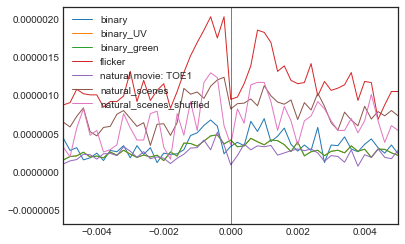

In [146]:
train1 = dft.times[dft.index[2]]
train2 = dft.times[dft.index[3]]
for stim in nwb_data['stimulus']['presentation'].keys()[:-1]:
    if stim != 'full field flashes':
        stimulus_times = np.array(nwb_data['stimulus']['presentation'][stim]['timestamps'])
        a = ephys.ccg(train1,train2,(-1,1),0.0002,spikerange=(stimulus_times[0],stimulus_times[-1]))
        plt.plot(a[1][:-1],a[0]-np.mean(a[0][:10]),label=stim,lw=1)
plt.gca().axvline(0,color='k',lw=0.5)
plt.xlim(-.005,.005)
plt.gca().legend()

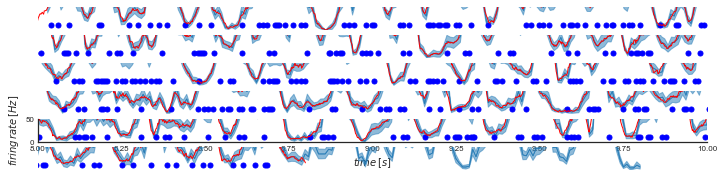

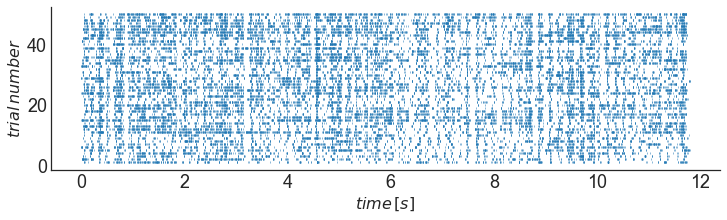

In [116]:
post=10.8

spike_times = dft.times[dft.index[3]]
stimulus_times =  np.array(nwb_data['stimulus']['presentation']['natural_scenes']['timestamps'][::118])
smoothed,minima,minima2 = rp.get_events(spike_times,stimulus_times,post=post,threshold=0.2,boxcar_size=10.,binsize=.002)

f,axes = plt.subplots(6,1,figsize=(12,3))
#ax.plot(ev,np.ones(len(ev))*10.,'bo')
for i,ax in enumerate(axes):
    if i !=4:
        psth.psth_line(spike_times,stimulus_times,pre=0.,post=post,binsize=0.01,output='fig',timeDomain=True,axes=ax,ymax=50,labels=False,error='shaded',color=sns.color_palette()[0])
        ephys.cleanAxes(ax,total=True)
    else:
        psth.psth_line(spike_times,stimulus_times,pre=0.,post=post,binsize=0.01,output='fig',timeDomain=True,axes=ax,ymax=50,labelsize=8,axis_labelsize=10,error='shaded',color=sns.color_palette()[0])
    #ax.plot(minima,np.ones(len(minima))*18.,'ro')
    ax.plot(minima2,np.ones(len(minima2))*post,'bo',ms=5)
    ax.plot(np.linspace(0,post,len(smoothed)),smoothed,'r-',lw=1)
    #ax.plot(np.linspace(0,15,len(moving)),moving,'b-')
    ax.set_xlim(i*2.,i*2.+2)

panelname = 'flicker_first_spike_V1_PSTH'
#plt.gcf().savefig(os.path.join(basepath,'figures','panels',panelname+'.png'),fmt='png',dpi=300)
#plt.gcf().savefig(os.path.join(basepath,'figures','panels',panelname+'.eps'),fmt='eps')

f,ax=plt.subplots(1,1,figsize=(12,3))
dump=ephys.raster(spike_times,stimulus_times,pre=0.0,post=post,timeDomain=True,axes=ax,markersize=4.2,color=sns.color_palette()[0])
# ax.set_xlim(9.4,9.6)
panelname = 'flicker_first_spike_V1_raster'
#plt.gcf().savefig(os.path.join(basepath,'figures','panels',panelname+'.png'),fmt='png',dpi=300)
#plt.gcf().savefig(os.path.join(basepath,'figures','panels',panelname+'.eps'),fmt='eps')

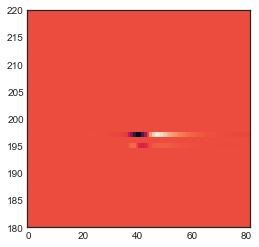

In [142]:
plt.imshow(dft.template[dft.index[3]].T)
plt.ylim(180,220)
plt.gca().set_aspect(2)

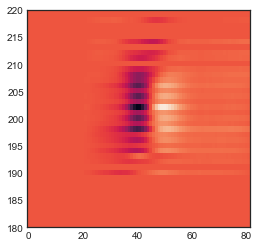

In [141]:
plt.imshow(dft.template[dft.index[6]].T)
plt.ylim(180,220)
plt.gca().set_aspect(2)

what should we store? what should we measure?

Loop over all pairs

In [ ]:
for j,nwb_path in enumerate(dfv.nwb_id.unique()[11:12]):
    cell1=[]
    cell2=[]
    nwb_id=[]
    depth1=[]
    depth2=[]
    # layer2=[]
    # layer1=[]
    class2=[]
    class1=[]
    probe2=[]
    probe1=[]
    ccgs=[]
    count=0
    dft=dfv[dfv.nwb_id==nwb_path]
    nwb_data = nwbs[nwb_path]
    if 'natural_scenes' in nwb_data['stimulus']['presentation'].keys():
        dft = dft.sort_values('depth')
        
        trials = np.array(nwb_data['stimulus']['presentation']['natural_scenes']['timestamps'][::118]).shape[0]
        pop_dt_zscore = np.zeros((trials,dft.shape[0]))
        pop_amp_zscore= np.zeros((trials,dft.shape[0]))
        stimulus_times = np.array(nwb_data['stimulus']['presentation']['natural_scenes']['timestamps'][::118])
        
        for i,index1 in enumerate(dft.index):
            dfz=dft[i:]
            times1=dft.times[index1]
            count+=1 
            print '\r '+str(j)+'/'+str(len(dfv.nwb_id.unique()))+' '+nwb_path+' '+str(count/float(len(dft.index))),

            for ii,index2 in enumerate(dfz.index):
                cell1.extend([dft.cell[index1]])
                cell2.extend([dft.cell[index2]])
                nwb_id.extend([nwb_path])
                depth1.extend([dft.depth[index1]])
                depth2.extend([dft.depth[index2]])
#                 layer2.extend([dft.layer[index2]])
#                 layer1.extend([dft.layer[index1]])
                class2.extend([dft.waveform_class[index2]])
                class1.extend([dft.waveform_class[index1]])
                probe2.extend([dft.probe[index2]])
                probe1.extend([dft.probe[index1]])
                train1 = dft.times[index1]
                train2 = dft.times[index2]
                all_ccgs={}
                for stim in nwb_data['stimulus']['presentation'].keys():
                    stimulus_times = np.array(nwb_data['stimulus']['presentation'][stim]['timestamps'])
                    all_ccgs[stim]=ephys.ccg(train1,train2,(-1,1),0.0002,spikerange=(stimulus_times[0],stimulus_times[-1]))
                ccgs.extend([all_ccgs])

    df_ccgs = pd.DataFrame({'cell1':cell1,
                            'cell2':cell2,
                            'nwb_id':nwb_id,
                            'depth1':depth1,
                            'depth2':depth2,
                            'class2':class2,
                            'class1':class1,
                            'probe2':probe2,
                            'probe1':probe1,
                            'ccgs':ccgs,
                           })
#     df_ccgs.to_hdf('df_ccgs_withEyetracking'+os.path.basename(nwb_path).strip('.nwb')+'.hdf','data')
    df_ccgs.to_pickle('df_ccgs_withEyetracking'+os.path.basename(nwb_path).strip('.nwb')+'.pkl')

In [ ]:
print 'df_ccgs_withEyetracking'+os.path.basename(nwb_path).strip('.nwb')+'.hdf'

In [35]:
nwb_data['stimulus']['presentation'].keys()

[u'binary',
 u'binary_UV',
 u'binary_green',
 u'flicker',
 u'full field flashes',
 u'natural movie: TOE1',
 u'natural_scenes',
 u'natural_scenes_shuffled',
 u'spontaneous epoch 1']

In [37]:
import h5py

In [39]:
h = h5py.File('df_ccgs_withEyetracking'+os.path.basename(nwb_path).strip('.nwb')+'.hdf')

In [69]:
h['data'].keys()

[u'axis0', u'axis1', u'block0_values']

In [70]:
pd.read_hdf('df_ccgs_withEyetracking'+os.path.basename(nwb_path).strip('.nwb')+'.hdf')

AttributeError: Attribute 'block0_items_variety' does not exist in node: '/data'

In [ ]:
for i,pair in enumerate(dft.index):
    #set threshold:
    cell1 = dft.cell1[index]
    cell2 = dft.cell2[index]
    ccgs = dft.ccgs[index]
    ccg = ccgs[stimulus_name]

In [31]:
stimulus_name = 'natural_scenes'
for j,nwb_path in enumerate(dfv.nwb_id.unique()):
    dft = pd.read_hdf('df_ccgs_withEyetracking'+os.path.basename(nwb_path).strip('.nwb')+'.hdf','data')
    nwb_data = nwbs[nwb_path]
    
    for i,pair in enumerate(dft.index):
        #set threshold:
        cell1 = dft.cell1[index]
        cell2 = dft.cell2[index]
        ccgs = dft.ccgs[index]
        ccg = ccgs[stimulus_name]

df_ccgs_withEyetrackingM227398_insertion1_withEyetracking.hdf
df_ccgs_withEyetrackingM260685_insertion1_withEyetracking.hdf
df_ccgs_withEyetrackingM260686_insertion1_V1_withEyetracking3.hdf
df_ccgs_withEyetrackingM310008_07-27-13_v1_angled_d_withEyetracking.hdf
df_ccgs_withEyetrackingM310008_07-35-06_v1_angled_d_withEyetracking.hdf
df_ccgs_withEyetrackingM310008_08-52-48_v1_angled3_d2_withEyetracking.hdf
df_ccgs_withEyetrackingM319891_dual_01092017_withEyetracking.hdf
df_ccgs_withEyetrackingM319891_dual_30082017_withEyetracking.hdf
df_ccgs_withEyetrackingM319891_dual_31082017_withEyetracking.hdf
df_ccgs_withEyetrackingM319892_dual_23082017_withEyetracking.hdf
df_ccgs_withEyetrackingM319892_dual_24082017_withEyetracking.hdf
df_ccgs_withEyetrackingM319892_dual_25082017_withEyetracking1.hdf


In [24]:
for j,nwb_path in enumerate(dfv.nwb_id.unique()[:6]):
    print os.path.basename(nwb_path).strip('.nwb')

M227398_insertion1_withEyetracking
M260685_insertion1_withEyetracking
M260686_insertion1_V1_withEyetracking3
M310008_07-27-13_v1_angled_d_withEyetracking
M310008_07-35-06_v1_angled_d_withEyetracking
M310008_08-52-48_v1_angled3_d2_withEyetracking


In [23]:
for j,nwb_path in enumerate(dfv.nwb_id.unique()[6:8]):
    print os.path.basename(nwb_path).strip('.nwb')

M319891_dual_01092017_withEyetracking
M319891_dual_30082017_withEyetracking


In [22]:
for j,nwb_path in enumerate(dfv.nwb_id.unique()[8:10]):
    print os.path.basename(nwb_path).strip('.nwb')

M319891_dual_31082017_withEyetracking
M319892_dual_23082017_withEyetracking


In [19]:
for j,nwb_path in enumerate(dfv.nwb_id.unique()[10:12]):
    print os.path.basename(nwb_path).strip('.nwb')

M319892_dual_24082017_withEyetracking
M319892_dual_25082017_withEyetracking1
